### Problem statement: 
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Melanoma Detection Assignment/skin_cancer/Train") #root_path = 'gdrive/My Drive/your_project_folder/'
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Melanoma Detection Assignment/skin_cancer/Test') #https://drive.google.com/drive/folders/1BArhOf3GHBDAeqqs-CdQ_QqomR1UV_5x?usp=sharing

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## train dataset
## seed=123 used while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
## resized images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, batch_size=batch_size, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2,subset='training'
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## validation dataset
## seed=123 used while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
## resized images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test, batch_size=batch_size, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2,subset='validation'
)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [8]:
# Listed out all the classes of skin cancer and stored them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Created a code to visualize one instance of all the nine classes present in the dataset

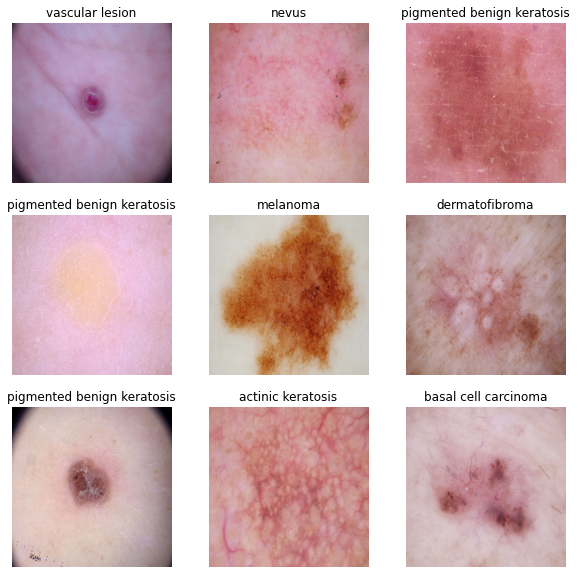

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
model1=Sequential([
                  layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)),
                  layers.Conv2D(16,3,padding='same',activation='relu'),
                  layers.MaxPool2D(),
                  layers.Conv2D(32,3,padding='same',activation='relu'),
                  layers.MaxPool2D(),
                  layers.Conv2D(64,3,padding='same',activation='relu'),
                  layers.MaxPool2D(),
                  layers.Flatten(),
                  layers.Dense(128,activation='relu'),
                  layers.Dense(9,activation='softmax')
              ])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
### Appropirate optimiser and loss function chosen
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [14]:
epochs = 20
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 20s 43ms/step - loss: 2.0077 - accuracy: 0.2612 - val_loss: 2.2933 - val_accuracy: 0.2609
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.7700 - accuracy: 0.3778 - val_loss: 2.3754 - val_accuracy: 0.2609
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.5287 - accuracy: 0.4621 - val_loss: 2.1306 - val_accuracy: 0.2609
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4086 - accuracy: 0.5140 - val_loss: 3.0081 - val_accuracy: 0.2609
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3089 - accuracy: 0.5368 - val_loss: 2.1020 - val_accuracy: 0.3043
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.2263 - accuracy: 0.5698 - val_loss: 2.3166 - val_accuracy: 0.2609
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.2017 - accuracy: 0.5798 - val_loss: 2.8438 - val_accuracy: 0.2174
Epoch 8/20
56/56 [=====

### Visualizing training results

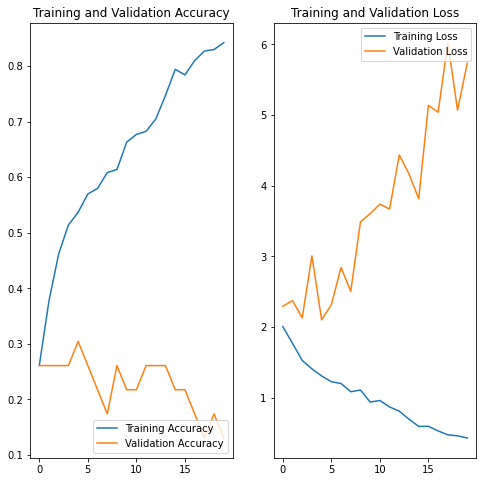

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

There is clear evidence of overfitting in the above graph. This is evident from the below facts:

1. Even if accuracy of train dataset is increasing the validation dataset accuracy is decreasing.
2. Even if loss of train dataset is decreasing the validation dataset accuracy is increasing drastically.

In [16]:
# Data augumentation strategy 
aug_layer=keras.Sequential([
                  layers.experimental.preprocessing.RandomFlip(mode='horizontal',input_shape=(img_height,img_width,3)),
                  layers.experimental.preprocessing.RandomRotation(0.25)
])

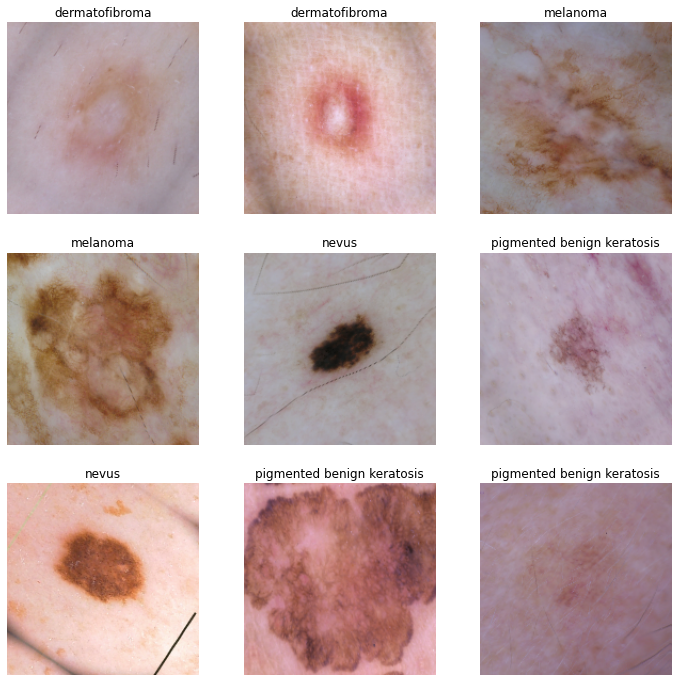

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(aug_layer(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [18]:
## Used Dropout layer in model building due to evidence of overfitting

model2=Sequential([
                  aug_layer,
                  layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)),
                  layers.Conv2D(16,3,padding='same',activation='relu'),
                  #layers.Dropout(0.6),
                  layers.MaxPool2D(),
                  #layers.Dropout(0.6),
                  layers.Conv2D(32,3,padding='same',activation='relu'),
                  #layers.BatchNormalization(),
                  #layers.Dropout(0.65),
                  layers.MaxPool2D(),
                  layers.Conv2D(64,3,padding='same',activation='relu'),
                  #layers.BatchNormalization(),
                  layers.Dropout(0.5),
                  layers.MaxPool2D(),
                  layers.Flatten(),
                  layers.Dropout(0.5),
                  layers.Dense(128,activation='relu'),
                  layers.Dropout(0.5),
                  #layers.BatchNormalization(),
                  layers.Dense(9,activation='softmax')
              ])

### Compiling the model

In [19]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [20]:
epochs = 20
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 28ms/step - loss: 2.1493 - accuracy: 0.2299 - val_loss: 2.2528 - val_accuracy: 0.0870
Epoch 2/20
56/56 [==============================] - 1s 25ms/step - loss: 1.7916 - accuracy: 0.3605 - val_loss: 2.0946 - val_accuracy: 0.3043
Epoch 3/20
56/56 [==============================] - 1s 25ms/step - loss: 1.6945 - accuracy: 0.3984 - val_loss: 2.0440 - val_accuracy: 0.3043
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.5786 - accuracy: 0.4403 - val_loss: 2.2118 - val_accuracy: 0.2174
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.5445 - accuracy: 0.4626 - val_loss: 2.0924 - val_accuracy: 0.2609
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4689 - accuracy: 0.4916 - val_loss: 2.1471 - val_accuracy: 0.3043
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4449 - accuracy: 0.5061 - val_loss: 2.1715 - val_accuracy: 0.3478
Epoch 8/20
56

### Visualizing the results

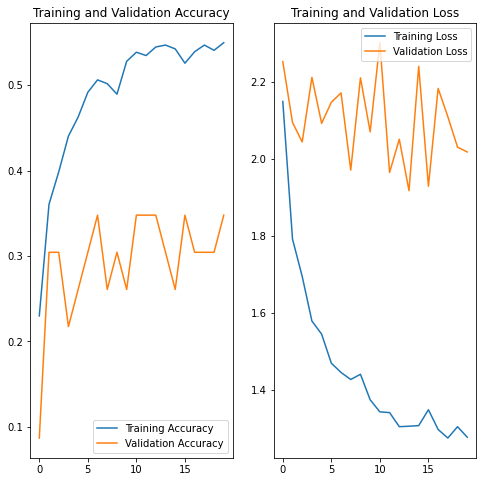

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:** Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

There seems to be some improvement in overfitting as compared to previous model by adding Data Augmentation strategy. However there is still scope of improvement for reducing overfitting.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
## Check for class imbalance
from glob import glob
import os 
path_list=[x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
cancer_type_list=[os.path.basename(os.path.dirname(i)) for i in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [23]:
original_df=pd.DataFrame(list(dict(zip(path_list,cancer_type_list)).items()),columns=['path','cancer_type'])

In [24]:
original_df['cancer_type'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: cancer_type, dtype: int64

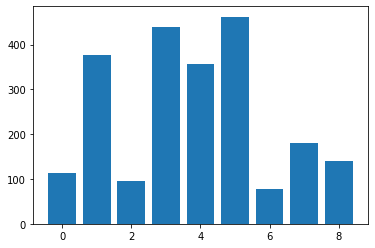

In [25]:
from sklearn.preprocessing import LabelEncoder 
from collections import Counter
x,y=original_df['path'],original_df['cancer_type']
y = LabelEncoder().fit_transform(y)
counter = Counter(y)
plt.bar(counter.keys(), counter.values())
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
"seborrheic keratosis" class has the least number of samples.

#### - Which classes dominate the data in terms proportionate number of samples?
"pigmented benign keratosis" dominate the data in terms proportionate number of samples.

#### **Todo:** Rectify the class imbalance
#### **Context:** We can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
path_to_training_dataset="/content/gdrive/MyDrive/Melanoma Detection Assignment/skin_cancer/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Detection Assignment/skin_cancer/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF31F792B10>: 100%|██████████| 500/500 [00:21<00:00, 23.63 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Detection Assignment/skin_cancer/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF31C4E5850>: 100%|██████████| 500/500 [00:23<00:00, 21.11 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Detection Assignment/skin_cancer/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF315C27C50>: 100%|██████████| 500/500 [00:22<00:00, 21.96 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Detection Assignment/skin_cancer/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF315BE96D0>: 100%|██████████| 500/500 [01:28<00:00,  5.65 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Detection Assignment/skin_cancer/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF31F792B10>: 100%|██████████| 500/500 [01:17<00:00,  6.49 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Detection Assignment/skin_cancer/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF315B28750>: 100%|██████████| 500/500 [00:20<00:00, 24.90 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Detection Assignment/skin_cancer/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FF315C63190>: 100%|██████████| 500/500 [00:42<00:00, 11.73 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Detection Assignment/skin_cancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF31DDE1E10>: 100%|██████████| 500/500 [00:18<00:00, 27.31 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Detection Assignment/skin_cancer/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF31F792B10>: 100%|██████████| 500/500 [00:18<00:00, 27.08 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Melanoma Detection Assignment/skin_cancer/Train/melanoma/output/melanoma_original_ISIC_0010131.jpg_1111c361-1e3f-4154-b669-a5a31a2e1701.jpg',
 '/content/gdrive/MyDrive/Melanoma Detection Assignment/skin_cancer/Train/melanoma/output/melanoma_original_ISIC_0000482.jpg_46930716-44d3-43a5-bdbf-29fa88642ef5.jpg',
 '/content/gdrive/MyDrive/Melanoma Detection Assignment/skin_cancer/Train/melanoma/output/melanoma_original_ISIC_0010394.jpg_d940d996-848d-4174-9381-7fd55c333c16.jpg',
 '/content/gdrive/MyDrive/Melanoma Detection Assignment/skin_cancer/Train/melanoma/output/melanoma_original_ISIC_0010175.jpg_2bf6e1b8-3609-41f8-b758-d2276babfe04.jpg',
 '/content/gdrive/MyDrive/Melanoma Detection Assignment/skin_cancer/Train/melanoma/output/melanoma_original_ISIC_0000168.jpg_3ff47432-2e34-461a-8e59-5caf47dfd90a.jpg',
 '/content/gdrive/MyDrive/Melanoma Detection Assignment/skin_cancer/Train/melanoma/output/melanoma_original_ISIC_0010358.jpg_b83eba3d-016f-47ef-99ca-7266be28491

In [30]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [31]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [32]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['path','cancer_type'])
new_df = original_df.append(df2)

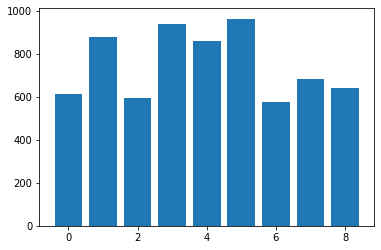

In [33]:
from sklearn.preprocessing import LabelEncoder 
from collections import Counter
x,y=new_df['path'],new_df['cancer_type']
y = LabelEncoder().fit_transform(y)
counter = Counter(y)
plt.bar(counter.keys(), counter.values())
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [34]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [35]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [37]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [38]:
## your code goes here
model3=Sequential([
                  layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)),
                  layers.Conv2D(16,3,padding='same',activation='relu'),
                  layers.MaxPool2D(),
                  #layers.Dropout(0.35),
                  layers.Conv2D(32,3,padding='same',activation='relu'),
                  layers.MaxPool2D(),
                  layers.Dropout(0.3),
                  layers.Conv2D(64,3,padding='same',activation='relu'),
                  layers.MaxPool2D(),
                  layers.Flatten(),
                  layers.Dropout(0.35),
                  layers.Dense(128,activation='relu'),
                  layers.Dropout(0.3),
                  layers.BatchNormalization(),
                  layers.Dense(9,activation='softmax')
              ])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [39]:
## your code goes here
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [40]:
# Train the Model
epochs = 20
## Used 20 epochs as mentioned in Evaluation Rubrics.
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 41s 61ms/step - loss: 2.0040 - accuracy: 0.2684 - val_loss: 1.9816 - val_accuracy: 0.2532
Epoch 2/20
169/169 [==============================] - 4s 25ms/step - loss: 1.5252 - accuracy: 0.4245 - val_loss: 1.5665 - val_accuracy: 0.3823
Epoch 3/20
169/169 [==============================] - 4s 25ms/step - loss: 1.3724 - accuracy: 0.4943 - val_loss: 1.5405 - val_accuracy: 0.4039
Epoch 4/20
169/169 [==============================] - 4s 25ms/step - loss: 1.3490 - accuracy: 0.5050 - val_loss: 1.3313 - val_accuracy: 0.4677
Epoch 5/20
169/169 [==============================] - 4s 24ms/step - loss: 1.1833 - accuracy: 0.5619 - val_loss: 1.1977 - val_accuracy: 0.5598
Epoch 6/20
169/169 [==============================] - 4s 25ms/step - loss: 1.0887 - accuracy: 0.6027 - val_loss: 1.1484 - val_accuracy: 0.5939
Epoch 7/20
169/169 [==============================] - 4s 25ms/step - loss: 1.0301 - accuracy: 0.6167 - val_loss: 1.0467 - val_accuracy: 0.6310
Epoch 8/2

#### **Todo:**  Visualize the model results

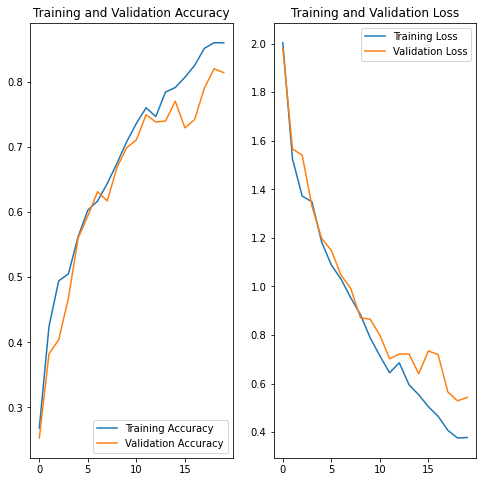

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



After augmentation with augmentor library, we are able to balance the class and built a good Model. 
Training Accuracy=86%, Validation Accuracy=81%. 
Thus Model is generalisable model now.
The problem of underfitting/overfitting is not visible anymore in the graph and also when comparing the Training and Validation Accuracy. So we can conclude that the class rebalance has definitely helped in improving the result.